In [1]:
import os
import SimpleITK as sitk
import numpy as np
import glob
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
from scipy.stats import skew


In [2]:
def nii_to_arr(nii_file):
    '''
    Converts nifti file to array. 
    Returns origin, spacing and the array.
    '''
    sitk_img = sitk.ReadImage(nii_file)
    origin = sitk_img.GetOrigin()
    spacing = sitk_img.GetSpacing()
    assert(spacing[2] == 12.)
    arr = sitk.GetArrayFromImage(sitk_img)
    
    return origin, spacing, arr

def arr_to_nii(origin, spacing, arr, nii_file):
    '''
    Converts array to nifti file.
    '''
    assert(spacing[2] == 12.)
    out = sitk.GetImageFromArray(arr)
    out.SetOrigin(origin)
    out.SetSpacing(spacing)
    sitk.WriteImage(out, nii_file)    
    
def extract_chamber(segmentation_file, intensity):
    '''
    Extracts LV and LVMC from segmented image.
    '''
    origin, spacing, img_arr = nii_to_arr(segmentation_file)
    assert(spacing[2] == 12.)
    img_arr_roi = np.where(img_arr == intensity, 1., 0.)
    return origin, spacing, img_arr_roi

def extract_voxel(nii_file):
    '''
    Returns voxel volume.
    '''
    sitk_img = sitk.ReadImage(nii_file)
    assert(sitk_img.GetSpacing()[2] == 12.)
    #print(sitk_img.GetSpacing()[0],sitk_img.GetSpacing()[1],sitk_img.GetSpacing()[2])
    return sitk_img.GetSpacing()[0]*sitk_img.GetSpacing()[1]*sitk_img.GetSpacing()[2]

In [3]:
chamber_volume_nnunet = {}
chamber_intensity = {'LV': 3.,
                    'LVMC': 2., 
                    }
nnunet_images_suffix = '.nii.gz'

In [4]:
nnunet_path = '/Users/saurabh/sample/uh_images/'

### Volume Features

In [5]:
path = os.getcwd()
path

'/Users/saurabh/Desktop/HeartProjects/Exhalted/Params/Code_EXH'

In [6]:
patient_dirs = glob.glob(nnunet_path+'*')
patient_ids = [re.search('(EXH)(.+)',dir_name).group(2) for dir_name in patient_dirs]
print(len(patient_ids))

57


In [7]:
def chamber_vol_func(patient_id):
    '''
    Calculates LV and Myocardial volume
    '''
    path_out = nnunet_path + 'EXH' + patient_id + '/REST/z_12/components/'
    if not os.path.isdir(path_out):
        os.mkdir(path_out)

    nnunet_folder = f'{nnunet_path}EXH{patient_id}/REST/z_12/all_slices/'
    nnunet_images_prefix = f'EXH{patient_id}_CINE_SET-UP-8SAX-1RTVLA-1HLA_'

    if patient_id == '100B':
        nnunet_images_prefix = f'EXH{patient_id}_CINE_SET-UP-8SAX-1VLA-1HLA_'

    num_images = len(glob.glob(nnunet_folder+'*.gz'))

    for comp in ['LV','LVMC']:
        vol = []
        for t in range(num_images):
            rest_maskName = nnunet_folder + nnunet_images_prefix + str(t).zfill(4) + nnunet_images_suffix
            origin, spacing, rest_chamber = extract_chamber(rest_maskName, chamber_intensity[comp])
            voxel_vol = extract_voxel(rest_maskName)
            vol.append(np.sum(rest_chamber)*voxel_vol)
            #print(comp,t,np.sum(rest_chamber)*voxel_vol)
        chamber_volume_nnunet[comp] = vol
    return chamber_volume_nnunet

#### Plot volume vs time

max volume =  117302.44 
min volume =  92190.38
ejection fraction =  0.21


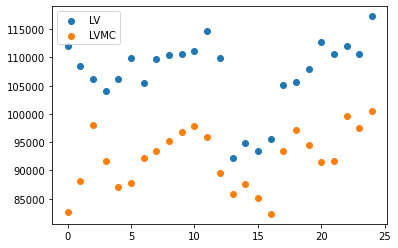

In [13]:
patient_id = '114'

chamber_volume_nnunet = chamber_vol_func(patient_id)
nnunet_folder = f'{nnunet_path}EXH{patient_id}/REST/z_12/all_slices/'
num_images = len(glob.glob(nnunet_folder+'*.gz'))

plt.scatter(np.arange(num_images),chamber_volume_nnunet['LV'],label='LV')
plt.scatter(np.arange(num_images),chamber_volume_nnunet['LVMC'],label='LVMC')
plt.legend();

es_vol = min(chamber_volume_nnunet['LV'])
ed_vol = max(chamber_volume_nnunet['LV'])
print('max volume = ', round(ed_vol,2), '\nmin volume = ', round(es_vol,2))
print('ejection fraction = ', round(1 - (es_vol/ed_vol),2))

In [14]:
class lvmcFeatures:
    def __init__(self, lvmc_volume, es, ed):
        self.vol = lvmc_volume
        self.vol_es = lvmc_volume[es]
        self.vol_ed = lvmc_volume[ed]
        self.vol_max = max(self.vol)
        self.vol_min = min(self.vol)
        
    def lvmc_std(self):
        return np.std(self.vol)/np.sqrt(len(self.vol))
    def lvmc_snr(self):
        return np.mean(self.vol)/np.std(self.vol)
    def lvmc_vol_es(self):
        return self.vol_es
    def lvmc_vol_ed(self):
        return self.vol_ed
    def lvmc_vol_max(self):
        return self.vol_max
    def lvmc_vol_min(self):
        return self.vol_min
    def lvmc_vol_es_equal_max(self):
        return int(self.vol_max == self.vol_es)
    def lvmc_vol_max_minus_min(self):
        return (self.vol_max - self.vol_min)/self.vol_max

In [15]:
class lvFeatures:
    def __init__(self, lv_volume, es, ed):
        self.vol = lv_volume
        self.vol_es = lv_volume[es]
        self.vol_ed = lv_volume[ed]
        
    def lv_std(self):
        return np.std(self.vol)/np.sqrt(len(self.vol))
    def lv_snr(self):
        return np.mean(self.vol)/np.std(self.vol)
    def lv_vol_es(self):
        return self.vol_es
    def lv_vol_ed(self):
        return self.vol_ed
    def stroke_volume(self):
        return self.vol_ed - self.vol_es
    def ejection_fraction(self):
        return (self.vol_ed - self.vol_es)/self.vol_ed

In [20]:
vol_data = []
for patient_id in patient_ids:

    nnunet_folder = f'{nnunet_path}EXH{patient_id}/REST/z_12/all_slices/'
    num_images = len(glob.glob(nnunet_folder+'*.gz'))
    print(f'Patient Id={patient_id}',f'number of images={num_images}')
    
    chamber_volume_nnunet = chamber_vol_func(patient_id)
    es = chamber_volume_nnunet['LV'].index(min(chamber_volume_nnunet['LV']))
    ed = chamber_volume_nnunet['LV'].index(max(chamber_volume_nnunet['LV']))
    
    vol_list = [patient_id]
    lvmc_features = lvmcFeatures(chamber_volume_nnunet['LVMC'],es,ed)

    vol_list.extend([lvmc_features.lvmc_std(), lvmc_features.lvmc_snr(), lvmc_features.lvmc_vol_es(), \
               lvmc_features.lvmc_vol_ed(), lvmc_features.lvmc_vol_max(), lvmc_features.lvmc_vol_min(),\
               lvmc_features.lvmc_vol_es_equal_max(), lvmc_features.lvmc_vol_max_minus_min()])
    
    lv_features = lvFeatures(chamber_volume_nnunet['LV'],es,ed)
    vol_list.extend([lv_features.lv_std(), lv_features.lv_snr(), lv_features.lv_vol_es(), \
               lv_features.lv_vol_ed(), lv_features.stroke_volume(), lv_features.ejection_fraction()])
    
    vol_data.append(vol_list)

Patient Id=153 number of images=9
Patient Id=154 number of images=11
Patient Id=162 number of images=8
Patient Id=191 number of images=25
Patient Id=109 number of images=7
Patient Id=164 number of images=8
Patient Id=190 number of images=25
Patient Id=199 number of images=25
Patient Id=130 number of images=12
Patient Id=100B number of images=17
Patient Id=200 number of images=25
Patient Id=201 number of images=25
Patient Id=123 number of images=21
Patient Id=124 number of images=9
Patient Id=170 number of images=6
Patient Id=184 number of images=8
Patient Id=183 number of images=13
Patient Id=141 number of images=8
Patient Id=146 number of images=6
Patient Id=179 number of images=9
Patient Id=114 number of images=25
Patient Id=147 number of images=7
Patient Id=149 number of images=8
Patient Id=136A number of images=9
Patient Id=185 number of images=9
Patient Id=135 number of images=12
Patient Id=132 number of images=13
Patient Id=103 number of images=10
Patient Id=168 number of images=

In [21]:
len(vol_data)

57

In [22]:
vol_df = pd.DataFrame()
vol_df = pd.DataFrame(data=vol_data, columns=['patient_id', 'lvmc_std', 'lvmc_snr', 'lvmc_vol_es', \
        'lvmc_vol_ed', 'lvmc_vol_max', 'lvmc_vol_min','lvmc_vol_es_equal_max', 'lvmc_vol_max_minus_min',\
        'lv_std', 'lv_snr', 'lv_vol_es', 'lv_vol_ed', 'stroke_volume', 'ejection_fraction'])

In [23]:
vol_df.shape

(57, 15)

In [24]:
vol_df.head()

,patient_id,lvmc_std,lvmc_snr,lvmc_vol_es,lvmc_vol_ed,lvmc_vol_max,lvmc_vol_min,lvmc_vol_es_equal_max,lvmc_vol_max_minus_min,lv_std,lv_snr,lv_vol_es,lv_vol_ed,stroke_volume,ejection_fraction
0,153,1362.454538,19.772862,78788.250000,85015.500000,85489.312500,73305.562500,0,0.142518,7965.467931,3.028929,39664.875000,106269.375000,66604.500000,0.626752
1,154,1170.807087,26.140431,109586.062500,103155.750000,109586.062500,94762.500000,1,0.135269,9425.673423,3.012396,46027.500000,130027.687500,84000.187500,0.646018
2,162,931.932994,27.155585,71613.375000,71071.875000,75674.625000,67416.750000,0,0.109123,4889.557224,4.245226,38920.312500,81428.062500,42507.750000,0.522028
3,191,628.804706,34.786485,113767.084884,103040.360091,114963.373894,103040.360091,0,0.103711,6097.426044,3.482814,58658.037807,151888.828014,93230.790206,0.613809
4,109,2522.159368,18.556770,111413.625000,126507.937500,135239.625000,111413.625000,0,0.176176,15817.902632,2.284888,42440.062500,153447.562500,111007.500000,0.723423


In [25]:
vol_df.describe().T

,count,mean,std,min,25%,50%,75%,max
lvmc_std,57.0,1797.558352,978.553481,628.804706,1153.427697,1576.147548,2157.732959,5292.798928
lvmc_snr,57.0,23.563425,9.398134,6.777910,16.904342,21.800929,29.353887,51.752073
lvmc_vol_es,57.0,119454.560966,34094.778466,66739.875000,99432.937500,111481.312500,136187.250000,245279.123421
lvmc_vol_ed,57.0,117516.593433,26976.081444,65995.312500,101531.250000,113095.916148,131003.510365,200697.419636
lvmc_vol_max,57.0,127911.039980,32967.862905,71816.437500,109586.062500,122446.687500,143159.062500,249944.650562
lvmc_vol_min,57.0,108822.267145,27850.475428,59294.250000,91613.147363,106018.453125,128538.562500,200697.419636
lvmc_vol_es_equal_max,57.0,0.192982,0.398147,0.000000,0.000000,0.000000,0.000000,1.000000
lvmc_vol_max_minus_min,57.0,0.147485,0.058346,0.051396,0.107206,0.135528,0.180286,0.321380
lv_std,57.0,8757.182215,3055.657135,1293.227392,7026.437692,9064.454540,10607.786669,15817.902632
lv_snr,57.0,4.544664,3.082525,2.119069,3.227912,3.573549,4.431670,16.560371


In [26]:
vol_df.sort_values(by=['ejection_fraction'],ascending=True).head()

,patient_id,lvmc_std,lvmc_snr,lvmc_vol_es,lvmc_vol_ed,lvmc_vol_max,lvmc_vol_min,lvmc_vol_es_equal_max,lvmc_vol_max_minus_min,lv_std,lv_snr,lv_vol_es,lv_vol_ed,stroke_volume,ejection_fraction
50,188,1153.427697,51.752073,138101.296538,131003.510365,138101.296538,131003.510365,1,0.051396,5913.262444,12.932917,148442.441956,182004.159358,33561.717402,0.184401
20,114,1034.658434,17.811026,85760.062500,100583.625000,100583.625000,82308.000000,0,0.181696,1293.227392,16.560371,92190.375000,117302.437500,25112.062500,0.214080
9,100B,2806.696077,11.717112,122988.187500,164616.000000,164616.000000,118114.687500,0,0.282484,2768.218732,16.263933,164954.437500,215178.562500,50224.125000,0.233407
12,123,632.677214,35.794174,104794.921875,103072.265625,112374.609375,99684.375000,0,0.112928,1969.364777,13.761918,102096.093750,136032.421875,33936.328125,0.249472
54,119,1790.748163,21.044772,137337.937500,135984.187500,155748.937500,133547.437500,0,0.142547,3033.372628,8.487487,78179.062500,116693.250000,38514.187500,0.330046


In [27]:
vol_df.to_csv('vol.csv')

### 3D features: Pyradiomics

In [28]:
from radiomics import featureextractor

In [29]:
extractor = featureextractor.RadiomicsFeatureExtractor()

In [30]:
pyrads_3d_columns = ['original_shape_Elongation', 'original_shape_Flatness',
       'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength',
       'original_shape_Maximum2DDiameterColumn',
       'original_shape_Maximum2DDiameterRow',
       'original_shape_Maximum2DDiameterSlice',
       'original_shape_Maximum3DDiameter', 'original_shape_MeshVolume',
       'original_shape_MinorAxisLength', 'original_shape_Sphericity',
       'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio',
       'original_shape_VoxelVolume']

In [31]:
def extract_roi(mask_arr, raw_file):
    origin, spacing, raw_arr_roi = nii_to_arr(raw_file)
    roi = np.multiply(mask_arr, raw_arr_roi)
    
    return origin, spacing, roi

In [32]:
def lv_pyrads_3d_stats(pyrads_3d_features, es, ed):
    min_val = np.amin(pyrads_3d_features, axis = 0)
    max_val = np.amax(pyrads_3d_features, axis = 0)
    mean_val = np.mean(pyrads_3d_features, axis = 0)
    median = np.median(pyrads_3d_features, axis = 0)
    std_dev = np.std(pyrads_3d_features, axis = 0)
    snr = mean_val/std_dev
    es_val = pyrads_3d_features[es]
    ed_val = pyrads_3d_features[ed]

    return min_val, max_val, mean_val, median, std_dev, snr ,es_val, ed_val

In [35]:
def lv_pyrads_3d_func(patient_id):
    shape_first = 22
    shape_last = 35

    comp = 'LV'
    nnunet_folder = nnunet_path + 'EXH' + patient_id + '/REST/z_12/all_slices/'
    num_images = len(glob.glob(nnunet_folder+'*.gz'))
    print('number of images = ',num_images)
    pyrads_3d_features = np.zeros((num_images, shape_last-shape_first+1))
    
    raw_folder_names = {'bias_corrected', 'normalized_bright_regions', 'raw'}
    raw_image_path = nnunet_path + 'EXH' + patient_id + '/REST/z_12/'
    raw_folder = list(set(os.listdir(raw_image_path)) & raw_folder_names)[0]
    raw_image_path += raw_folder
    raw_images_prefix = f'EXH{patient_id}_CINE_SET-UP-8SAX-1RTVLA-1HLA_'
    raw_images_suffix = '__0000.nii.gz'

    if patient_id == '100B':
        raw_images_prefix = f'EXH{patient_id}_CINE_SET-UP-8SAX-1VLA-1HLA_'
    
    nnunet_images_prefix = raw_images_prefix
        
    for t in range(num_images):
        mask_file = nnunet_folder + nnunet_images_prefix + str(t).zfill(4) + nnunet_images_suffix
        raw_file = raw_image_path + '/' + raw_images_prefix + str(t).zfill(4) + raw_images_suffix
        origin, spacing, mask_arr = extract_chamber(mask_file, chamber_intensity['LV'])
        _, _, roi_arr = extract_roi(mask_arr, raw_file)

        roi_nii = f'{nnunet_path}EXH{patient_id}/REST/z_12/components/roi_{str(t)}.nii.gz'
        mask_nii = f'{nnunet_path}EXH{patient_id}/REST/z_12/components/mask_{str(t)}.nii.gz'
        arr_to_nii(origin, spacing, roi_arr, roi_nii)          
        arr_to_nii(origin, spacing, mask_arr, mask_nii)  
        result = extractor.execute(os.path.join(roi_nii),os.path.join(mask_nii));
        
        for ind, shape_feature in enumerate(pyrads_3d_columns):
            pyrads_3d_features[t-t_start, ind] = result[shape_feature]

    return pyrads_3d_features

In [ ]:
pyrads_3d_all_patients = []
i_start = 0
for i in range(i_start, len(patient_ids)):
    patient_id = patient_ids[i]
    print(f'Patient Id={patient_id}')

    chamber_volume_nnunet = chamber_vol_func(patient_id)
    es = chamber_volume_nnunet['LV'].index(min(chamber_volume_nnunet['LV'])) 
    ed = chamber_volume_nnunet['LV'].index(max(chamber_volume_nnunet['LV'])) 

    pyrads_3d_features = lv_pyrads_3d_func(patient_id)
    min_val, max_val, mean_val, median, std_dev, snr ,es_val, ed_val = \
    lv_pyrads_3d_stats(pyrads_3d_features, es, ed)
    
    pyrads_3d_per_patient = []
    pyrads_3d_per_patient.extend(min_val)
    pyrads_3d_per_patient.extend(max_val)
    pyrads_3d_per_patient.extend(mean_val)
    pyrads_3d_per_patient.extend(median)
    pyrads_3d_per_patient.extend(std_dev)
    pyrads_3d_per_patient.extend(snr)
    pyrads_3d_per_patient.extend(es_val)
    pyrads_3d_per_patient.extend(ed_val)
    
    pyrads_3d_all_patients.append(pyrads_3d_per_patient)

In [37]:
num_features = len(pyrads_3d_all_patients[0])
num_features

112

In [38]:
len(pyrads_3d_all_patients)

57

In [39]:
full_features = []
for keyword in ['min', 'max', 'mean', 'median', 'std_dev', 'snr', 'es_val', 'ed_val']:
     full_features.extend([f'{keyword}_{feat}' for feat in pyrads_3d_columns])

In [40]:
pyrads_3d_df = pd.DataFrame()
pyrads_3d_df = pd.DataFrame(data=pyrads_3d_all_patients, columns=full_features)
pyrads_3d_df['patient_id'] = patient_ids

In [41]:
pyrads_3d_df.head()

,min_original_shape_Elongation,min_original_shape_Flatness,min_original_shape_LeastAxisLength,min_original_shape_MajorAxisLength,min_original_shape_Maximum2DDiameterColumn,min_original_shape_Maximum2DDiameterRow,min_original_shape_Maximum2DDiameterSlice,min_original_shape_Maximum3DDiameter,min_original_shape_MeshVolume,min_original_shape_MinorAxisLength,...,ed_val_original_shape_Maximum2DDiameterRow,ed_val_original_shape_Maximum2DDiameterSlice,ed_val_original_shape_Maximum3DDiameter,ed_val_original_shape_MeshVolume,ed_val_original_shape_MinorAxisLength,ed_val_original_shape_Sphericity,ed_val_original_shape_SurfaceArea,ed_val_original_shape_SurfaceVolumeRatio,ed_val_original_shape_VoxelVolume,patient_id
0,0.465877,0.428289,29.278647,62.527673,73.396611,75.105863,38.295724,76.298038,38669.304688,33.356377,...,92.195445,54.158333,93.411054,104904.343750,46.789588,0.736203,14611.078910,0.139280,106269.375000,153
1,0.535261,0.464772,31.088073,65.061814,75.105863,73.894456,41.545532,75.443066,45023.468750,35.649628,...,89.494501,58.223841,92.011718,128671.117188,51.046749,0.777686,15848.950767,0.123174,130027.687500,154
2,0.466832,0.383890,27.994273,65.667436,77.435457,74.464757,43.792836,81.030569,37890.898438,34.586747,...,81.412530,51.870783,85.237261,80063.031250,43.552077,0.711099,12633.063217,0.157789,81428.062500,162
3,0.405778,0.387128,34.085171,79.586113,85.955235,93.882268,42.085298,94.165008,57676.083911,35.819611,...,120.244185,59.041115,120.465067,150684.231441,49.004307,0.704417,19440.135711,0.129012,151888.828014,191
4,0.516088,0.433696,29.664223,61.725231,64.529547,66.424769,42.085107,66.974459,41424.750000,35.827985,...,101.595091,63.948832,102.946360,151871.007812,54.112955,0.728897,18885.775024,0.124354,153447.562500,109


In [42]:
pyrads_3d_df.to_csv('pyrads_3d.csv')

In [43]:
pyrads_3d_df.shape

(57, 113)

### 3D fractal features

In [44]:
def fractal_dimension(array, max_box_size = None, min_box_size = 1, n_samples = 10, n_offsets = 0, plot = False):
    
    #determine the scales to measure on
    if max_box_size == None:
        #default max size is the largest power of 2 that fits in the smallest dimension of the array:
        max_box_size = int(np.floor(np.log2(np.min(array.shape))))
    scales = np.floor(np.logspace(max_box_size,min_box_size, num = n_samples, base =2 ))
    scales = np.unique(scales) #remove duplicates that could occur as a result of the floor
    
    #get the locations of all non-zero pixels
    locs = np.where(array > 0)
    voxels = np.array([(x,y,z) for x,y,z in zip(*locs)])
    
    #count the minimum amount of boxes touched
    Ns = []
    #loop over all scales
    for scale in scales:
        touched = []
        if n_offsets == 0:
            offsets = [0]
        else:
            offsets = np.linspace(0, scale, n_offsets)
        #search over all offsets
        for offset in offsets:
            bin_edges = [np.arange(0, i, scale) for i in array.shape]
            bin_edges = [np.hstack([0-offset,x + offset]) for x in bin_edges]
            H1, e = np.histogramdd(voxels, bins = bin_edges)
            touched.append(np.sum(H1>0))
        Ns.append(touched)
    Ns = np.array(Ns)
    
    #From all sets N found, keep the smallest one at each scale
    Ns = Ns.min(axis=1)
   
    #Only keep scales at which Ns changed
    scales  = np.array([np.min(scales[Ns == x]) for x in np.unique(Ns)])
    
    Ns = np.unique(Ns)
    Ns = Ns[Ns > 0]
    scales = scales[:len(Ns)]
    #perform fit
    coeffs = np.polyfit(np.log(1/scales), np.log(Ns),1)
    #make plot
    if plot:
        fig, ax = plt.subplots(figsize = (8,6))
        ax.scatter(np.log(1/scales), np.log(np.unique(Ns)), c = "teal", label = "Measured ratios")
        ax.set_ylabel("$\log N(\epsilon)$")
        ax.set_xlabel("$\log 1/ \epsilon$")
        fitted_y_vals = np.polyval(coeffs, np.log(1/scales))
        ax.plot(np.log(1/scales), fitted_y_vals, "k--", label = f"Fit: {np.round(coeffs[0],3)}X+{coeffs[1]}")
        ax.legend();
    return(coeffs[0], coeffs[1])

In [45]:
def fractals_3d_stats_func(fractal_vals, es, ed):
    slope_vals = [ent[0] for ent in fractal_vals]
    inc_vals = [ent[1] for ent in fractal_vals]

    max_slope, max_inc = max(slope_vals), max(inc_vals)
    min_slope, min_inc = min(slope_vals), min(inc_vals)
    mean_slope, mean_inc = np.mean(slope_vals), np.mean(inc_vals)
    median_slope, median_inc = np.median(slope_vals), np.median(inc_vals)
    ed_slope, ed_inc = slope_vals[ed], inc_vals[ed]
    es_slope, es_inc = slope_vals[es], inc_vals[es]
    
    return [max_slope, max_inc, min_slope, min_inc, mean_slope, mean_inc, \
            median_slope, median_inc, ed_slope, ed_inc, es_slope, es_inc]

In [50]:
def fractals_3d_func(patient_id):
    nnunet_folder = f'{nnunet_path}EXH{patient_id}/REST/z_12/all_slices/'
    nnunet_images_prefix = f'EXH{patient_id}_CINE_SET-UP-8SAX-1RTVLA-1HLA_'

    if patient_id == '100B':
        nnunet_images_prefix = f'EXH{patient_id}_CINE_SET-UP-8SAX-1VLA-1HLA_'

    num_images = len(glob.glob(nnunet_folder+'*.gz'))
    print('num images = ', num_images,'\n ****')
    
    chamber_volume_nnunet = chamber_vol_func(patient_id)
    es = chamber_volume_nnunet['LV'].index(min(chamber_volume_nnunet['LV']))
    ed = chamber_volume_nnunet['LV'].index(max(chamber_volume_nnunet['LV']))
    
    lv_fractals = []
    lvmc_fractals = []
    for t in range(num_images):
        img_file = nnunet_folder + nnunet_images_prefix + str(t).zfill(4) + '.nii.gz'
        img = nib.load(img_file).get_fdata()  
        
        lv = np.where(img == 3, 1, 0)
        lvmc = np.where(img == 2, 1, 0)
        
        lv_slope, lv_inc = fractal_dimension(lv, max_box_size = None, min_box_size = 1, n_samples = 10, n_offsets = 0, plot = False)
        lvmc_slope, lvmc_inc = fractal_dimension(lvmc, max_box_size = None, min_box_size = 1, n_samples = 10, n_offsets = 0, plot = False)
        
        lv_fractals.append((lv_slope, lv_inc))
        lvmc_fractals.append((lvmc_slope, lvmc_inc))  
    
    return fractals_3d_stats_func(lv_fractals, es, ed), fractals_3d_stats_func(lvmc_fractals, es, ed)

In [51]:
fractals_3d_all_patients = []
for patient_id in patient_ids:
    print('patient_id = ',patient_id)
    nnunet_folder = f'{nnunet_path}EXH{patient_id}/REST/z_12/all_slices/'
    vals = fractals_3d_func(patient_id)
    
    fractals_3d_all_patients.append(vals[0]+vals[1])

patient_id =  153
num images =  9 
 ****
patient_id =  154
num images =  11 
 ****
patient_id =  162
num images =  8 
 ****
patient_id =  191
num images =  25 
 ****
patient_id =  109
num images =  7 
 ****
patient_id =  164
num images =  8 
 ****
patient_id =  190
num images =  25 
 ****
patient_id =  199
num images =  25 
 ****
patient_id =  130
num images =  12 
 ****
patient_id =  100B
num images =  17 
 ****
patient_id =  200
num images =  25 
 ****
patient_id =  201
num images =  25 
 ****
patient_id =  123
num images =  21 
 ****
patient_id =  124
num images =  9 
 ****
patient_id =  170
num images =  6 
 ****
patient_id =  184
num images =  8 
 ****
patient_id =  183
num images =  13 
 ****
patient_id =  141
num images =  8 
 ****
patient_id =  146
num images =  6 
 ****
patient_id =  179
num images =  9 
 ****
patient_id =  114
num images =  25 
 ****
patient_id =  147
num images =  7 
 ****
patient_id =  149
num images =  8 
 ****
patient_id =  136A
num images =  9 
 ****
pat

In [56]:
len(fractals_3d_all_patients)

57

In [57]:
full_features = []
for comp in ['lv_', 'lvmc_']:
    for key in ['max_', 'min_', 'mean_', 'median_', 'ed_', 'es_']:
        for coef in ['slope', 'inc']:
            full_features.append(comp+key+coef)

In [58]:
fractals_3d_df = pd.DataFrame()
fractals_3d_df = pd.DataFrame(data=fractals_3d_all_patients, columns=full_features)
fractals_3d_df['patient_id'] = patient_ids

In [55]:
fractals_3d_df.head()

,lv_max_slope,lv_max_inc,lv_min_slope,lv_min_inc,lv_mean_slope,lv_mean_inc,lv_median_slope,lv_median_inc,lv_ed_slope,lv_ed_inc,...,lvmc_min_inc,lvmc_mean_slope,lvmc_mean_inc,lvmc_median_slope,lvmc_median_inc,lvmc_ed_slope,lvmc_ed_inc,lvmc_es_slope,lvmc_es_inc,patient_id
0,2.479988,7.346413,1.963456,6.064861,2.275728,6.760670,2.342396,6.886595,2.458897,7.346413,...,6.965695,2.273299,7.181236,2.275288,7.238113,2.239110,7.315423,2.271066,7.039687,153
1,2.413301,7.404196,2.186582,6.476394,2.322058,7.036596,2.344578,7.186857,2.413301,7.404196,...,7.484620,2.338499,7.544748,2.324051,7.543040,2.324051,7.531694,2.377132,7.528839,154
2,2.366648,7.101825,2.074160,6.248441,2.213915,6.648769,2.183091,6.642925,2.366648,7.101825,...,6.980443,2.232655,7.121495,2.242075,7.118396,2.310661,7.293535,2.249362,7.070714,162
3,2.558215,8.257276,2.322868,7.386463,2.478927,7.865453,2.493921,7.980278,2.558215,8.257276,...,7.982848,2.421854,8.162983,2.426577,8.204169,2.409906,8.211593,2.420886,8.054498,191
4,2.557690,7.792839,2.048207,6.216915,2.405354,7.158140,2.426958,7.246218,2.555350,7.792839,...,7.537170,2.417745,7.761672,2.432243,7.819010,2.437533,7.942699,2.347765,7.537170,109


In [59]:
fractals_3d_df.to_csv('fractals_3d.csv')